# PyDeepGP tutorial

In [1]:
import numpy as np
import GPy
from pylab import *
%matplotlib inline
import os
from sys import path
np.random.seed(42)

In [2]:
# Add parent directory to path if deepgp is not there already
pwd = os.getcwd()
base_path = pwd[0:pwd.rfind(os.sep)]
path.insert(0,base_path)

In [3]:
import deepgp

In [5]:
# Utility to load sample data. It can be installed with pip. Otherwise just load some other data.
import pods

## Unsupervised learning (oil data)

In [14]:
# Load data
data = pods.datasets.oil_100()
Y = data['X']
labels =  data['Y'].argmax(axis=1)

# Number of latent dimensions per layer
Q1 = 5
# Q2 = 4
# Type of kernel per layer
kern1 = GPy.kern.RBF(Q1,ARD=True) + GPy.kern.Bias(Q1)
#kern2 = GPy.kern.RBF(Q2,ARD=True) + GPy.kern.Bias(Q2)

# Number of inducing points per layer (can be set to different if given as list).
num_inducing = 40

# Whether to use back-constraint for variational posterior
back_constraint = False

# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

In [15]:
m = deepgp.DeepGP([Y.shape[1],Q1],
                  Y,kernels=[kern1], 
                  num_inducing=num_inducing, 
                  back_constraint=back_constraint, 
                  encoder_dims = encoder_dims)

In [16]:
# Make sure initial noise variance gives a reasonable signal to noise ratio
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01

In [17]:
m.optimize(max_iters=5000, messages=True)

[<BarContainer object of 5 artists>, <BarContainer object of 5 artists>]

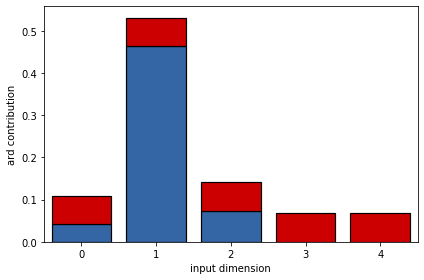

In [21]:
# Plot ARD scales per layer
m.obslayer.kern.plot_ARD()
#m.layer_0.kern.plot_ARD()

IndexError: list index out of range

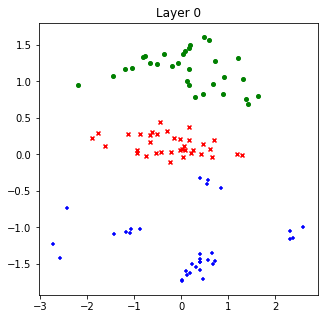

<Figure size 360x360 with 0 Axes>

In [22]:
# From the plots above, we see which ones are the dominant dimensions for each layer. 
# So we use these dimensions in the visualization of the latent space below.
plt.figure(figsize=(5,5))
deepgp.util.visualize_DGP(m, labels, layer=0, dims=[1,2]); plt.title('Layer 0')
plt.figure(figsize=(5,5))
deepgp.util.visualize_DGP(m, labels, layer=1, dims=[0,1]); plt.title('Layer 1')

## Supervised learning

In [23]:
# Load some mocap data.
data = pods.datasets.cmu_mocap_35_walk_jog()

Ntr = 100
Nts = 500


# All data represented in Y_all, which is the angles of the movement of the subject
Y_all = data['Y']
perm = np.random.permutation(Ntr+Nts)
index_training = np.sort(perm[0:Ntr])
index_test     = np.sort(perm[Ntr:Ntr+Nts])

Y_all_tr = Y_all[index_training,:]
Y_all_ts = Y_all[index_test,    :]


# Some of the features (body joints) to be used as inputs, and some as outputs
X_tr = Y_all_tr[:,0:55].copy()
Y_tr = Y_all_tr[:, 55:].copy()

X_ts = Y_all_ts[:,0:55].copy()
Y_ts = Y_all_ts[:, 55:].copy()

# TODO: You might need to normalize the input and/or output data.

Acquiring resource: cmu_mocap

Details of data: 
CMU Motion Capture data base. Captured by a Vicon motion capture system consisting of 12 infrared MX-40 cameras, each of which is capable of recording at 120 Hz with images of 4 megapixel resolution. Motions are captured in a working volume of approximately 3m x 8m. The capture subject wears 41 markers and a stylish black garment.

Please cite:
Please include this in your acknowledgements: The data used in this project was obtained from mocap.cs.cmu.edu.\nThe database was created with funding from NSF EIA-0196217.

Data will be stored in C:\Users\33617/ods_data_cache/cmu_mocap.

You must also agree to the following license:
From http://mocap.cs.cmu.edu. This data is free for use in research projects. You may include this data in commercially-sold products, but you may not resell this data directly, even in converted form. If you publish results obtained using this data, we would appreciate it if you would send the citation to your publis

[==============================]   0.331/0.331MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============================]   0.275/0.275MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============================]   0.330/0.330MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============================]   0.347/0.347MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============================]   0.339/0.339MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============================]   0.114/0.114MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
[==============================]   0.126/0.126MB                                                                                                                                                                                                                                       

[==============================]   0.321/0.321MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

[==============================]   0.317/0.317MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [24]:
# Number of latent dimensions (single hidden layer, since the top layer is observed)
Q = 5

# Define what kernels to use per layer
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(Q,ARD=False) + GPy.kern.Bias(X_tr.shape[1])

# Number of inducing points to use
num_inducing = 40

# Whether to use back-constraint for variational posterior
back_constraint = False

# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

In [25]:
m = deepgp.DeepGP([Y_tr.shape[1],Q,X_tr.shape[1]],
                  Y_tr, X_tr=X_tr,kernels=[kern1, kern2], 
                  num_inducing=num_inducing, back_constraint=back_constraint)

In [26]:
# Make sure initial noise variance gives a reasonable signal to noise ratio.
# Fix to that value for a few iterations to avoid early local minima
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01
    m.layers[i].Gaussian_noise.variance.fix()

In [27]:
display(m)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(40, 5)",,
obslayer.sum.rbf.variance,1.0,+ve,
obslayer.sum.rbf.lengthscale,"(5,)",+ve,
obslayer.sum.bias.variance,1.0,+ve,
obslayer.Gaussian_noise.variance,2.1261182745572187,+ve fixed,
obslayer.Kuu_var,"(40,)",+ve,
obslayer.latent space.mean,"(100, 5)",,
obslayer.latent space.variance,"(100, 5)",+ve,
layer_1.inducing inputs,"(40, 55)",,
layer_1.sum.rbf.variance,1.0,+ve,


In [28]:
m.optimize(max_iters=800, messages=True)

In [29]:
# Unfix noise variance now that we have initialized the model
for i in range(len(m.layers)):
    m.layers[i].Gaussian_noise.variance.unfix()

In [30]:
m.optimize(max_iters=1500, messages=True)

### Compare with GP

In [20]:
m_GP = GPy.models.SparseGPRegression(X=X_tr, Y=Y_tr, kernel=GPy.kern.RBF(X_tr.shape[1])+GPy.kern.Bias(X_tr.shape[1]), num_inducing=num_inducing)

In [21]:
m_GP.Gaussian_noise.variance = m_GP.Y.var()*0.01
m_GP.Gaussian_noise.variance.fix()
m_GP.optimize(max_iters=100, messages=True)
m_GP.Gaussian_noise.variance.unfix()
m_GP.optimize(max_iters=400, messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s19  006   2.463751e+03   4.986610e+02 
    00s33  027   2.339956e+03   5.774437e-11 
Runtime:     00s33
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s07  004   1.855557e+03   2.678079e+03 
    00s18  011   1.778417e+03   5.465010e-02 
    00s32  029   1.778190e+03   1.885596e-09 
Runtime:     00s32
Optimization status: Converged



In [22]:
def rmse(predictions, targets):
    return np.sqrt(((predictions.flatten() - targets.flatten()) ** 2).mean())


In [23]:
Y_pred = m.predict(X_ts)[0]
Y_pred_s = m.predict_withSamples(X_ts, nSamples=500)[0]
Y_pred_GP = m_GP.predict(X_ts)[0]

print('# RMSE DGP               : ' + str(rmse(Y_pred, Y_ts)))
print('# RMSE DGP (with samples): ' + str(rmse(Y_pred_s, Y_ts)))
print('# RMSE GP                : ' + str(rmse(Y_pred_GP, Y_ts)))

# RMSE DGP               : 3.03000726496
# RMSE DGP (with samples): 3.03436330576
# RMSE GP                : 3.02347121967
